In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [2]:
def get_metrics(y_true, preds):
    precision, recall, thresholds = precision_recall_curve(y_true, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
    return thresholds[ix], fscore[ix], precision[ix], recall[ix]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def evaluate_pipeline(pipeline):
    preds = pipeline.predict_proba(X_test)[:, 1]
    best_threshold, fscore, precision, recall = get_metrics(y_test, preds)
    cnf_matrix = confusion_matrix(y_test, preds>best_threshold)
    plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                          title='Confusion matrix')
    plt.show()
    return best_threshold, fscore, precision, recall

In [3]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [4]:
df = pd.read_csv("churn_data.csv")
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [5]:
final_transformers = []
for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

In [6]:
metrics = {}

Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629
Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


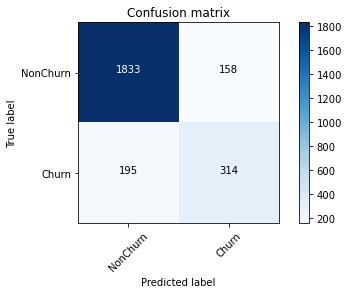

In [7]:
forest_pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])
forest_pipeline.fit(X_train, y_train)
metrics['Forest'] = evaluate_pipeline(forest_pipeline)

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597
Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


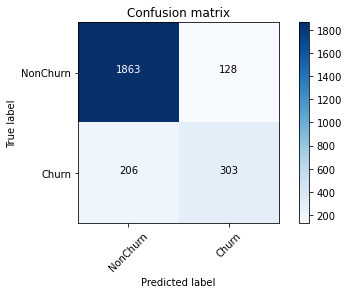

In [8]:
boosting_pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])
boosting_pipeline.fit(X_train, y_train)
metrics['boosting'] = evaluate_pipeline(boosting_pipeline)

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568
Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


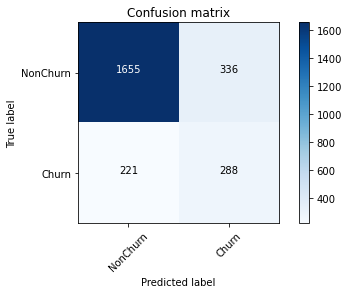

In [9]:
logistic_pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state=42)),
])
logistic_pipeline.fit(X_train, y_train)
metrics['logreg'] = evaluate_pipeline(logistic_pipeline)

2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [10]:
result = pd.DataFrame(metrics)
result["metric"] = ['best_threshold', 'fscore', 'precision', 'recall']
result

,Forest,boosting,logreg,metric
0,0.380000,0.408508,0.289522,best_threshold
1,0.641283,0.646121,0.509700,fscore
2,0.654397,0.703704,0.462400,precision
3,0.628684,0.597250,0.567780,recall


Лучшая модель: модель градиентного бустинга. Наиболее подходящяя метрика для данной задачи: precision так как максимизация её, минимизует FP, что снижает ненужные расходы на сохранение клиентов не уходящих в отток

3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [11]:
preds = boosting_pipeline.predict_proba(X_test)[:, 1]
best_threshold, fscore, precision, recall = get_metrics(y_test, preds)
cnf_matrix = confusion_matrix(y_test, preds>best_threshold)
cnf_matrix

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


array([[1863,  128],
       [ 206,  303]], dtype=int64)

In [12]:
FP = cnf_matrix[0, 1]
TN = cnf_matrix[1, 1]
print(f'выручка: {TN - FP} Долларов')

выручка: 175 Долларов


4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [17]:
params={"classifier__learning_rate": [0.1, 0.05],
        "classifier__min_samples_split": [2, 3],
        "classifier__min_samples_leaf": [1, 3],
        "classifier__max_depth":[3,5],
        }

grid = GridSearchCV(boosting_pipeline,
                    param_grid=params,
                    cv=5,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 5,
 'classifier__min_samples_leaf': 3,
 'classifier__min_samples_split': 2}

In [18]:
final_pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(learning_rate=0.1, max_depth=5, 
                                          min_samples_leaf=3, min_samples_split=2))
])
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.493367, F-Score=0.638, Precision=0.745, Recall=0.558
Confusion matrix, without normalization
[[1894   97]
 [ 226  283]]


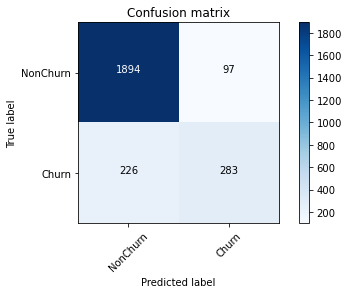

(0.4933670947834952,
 0.6382022471910112,
 0.7454068241469817,
 0.5579567779960707)

In [19]:
evaluate_pipeline(final_pipeline)

5. (опционально) Еще раз провести оценку экономической эффективности

In [20]:
preds = final_pipeline.predict_proba(X_test)[:, 1]
best_threshold, fscore, precision, recall = get_metrics(y_test, preds)
cnf_matrix = confusion_matrix(y_test, preds>best_threshold)
cnf_matrix

FP = cnf_matrix[0, 1]
TN = cnf_matrix[1, 1]
print(f'выручка: {TN - FP} Долларов')

Best Threshold=0.493367, F-Score=0.638, Precision=0.745, Recall=0.558
выручка: 186 Долларов
